In [2]:
import tensorflow as tf
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, Input, Dropout, BatchNormalization, Dot, Embedding, Flatten, Activation
from wordcloud import WordCloud
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint,LearningRateScheduler, TensorBoard
import matplotlib.pyplot as plt
%matplotlib inline

In [3]:
data = pd.read_csv('../artifacts/raw/animelist.csv', low_memory=True, usecols=['user_id', 'anime_id', 'rating'])

In [4]:
data.head()

,user_id,anime_id,rating
0,0,67,9
1,0,6702,7
2,0,242,10
3,0,4898,0
4,0,21,10


In [5]:
n_rating = data['user_id'].value_counts()
n_rating

user_id
11100    14429
10255     8403
4773      5735
6852      5406
16057     5080
         ...  
106          1
6846         1
92           1
26           1
10703        1
Name: count, Length: 15186, dtype: int64

In [6]:
len(data)

5000000

In [7]:
rating_df = data[data['user_id'].isin(n_rating[n_rating >400].index)].copy()

In [8]:
rating_df.head()

,user_id,anime_id,rating
213,2,24833,0
214,2,235,10
215,2,36721,0
216,2,40956,0
217,2,31933,0


In [9]:
len(rating_df)

3242641

In [10]:
min_rating = min(rating_df['rating'])
min_rating

0

In [11]:
max_rating = max(rating_df['rating'])
max_rating

10

In [12]:
avg_rating = rating_df['rating'].mean()
avg_rating

np.float64(4.122023992171813)

In [13]:
rating_df['rating'] = rating_df['rating'].apply(lambda x : (x-min_rating)/(max_rating-min_rating)).values.astype(np.float64)

In [14]:
rating_df

,user_id,anime_id,rating
213,2,24833,0.0
214,2,235,1.0
215,2,36721,0.0
216,2,40956,0.0
217,2,31933,0.0
...,...,...,...
4999916,16507,8985,0.0
4999917,16507,5454,0.0
4999918,16507,15911,0.0
4999919,16507,878,0.0


In [15]:
min(rating_df['rating']), max(rating_df['rating'])


(0.0, 1.0)

In [16]:
np.mean(rating_df['rating'])

np.float64(0.41220239921718105)

In [17]:
rating_df.duplicated().sum()

np.int64(0)

In [18]:
rating_df.isnull().sum()

user_id     0
anime_id    0
rating      0
dtype: int64

In [19]:
user_ids = rating_df['user_id'].unique().tolist()
len(user_ids)   

4193

In [20]:
user2user_encoder = {x : i for i , x in enumerate(user_ids)}
user2user_decoder = {i : x for i, x in enumerate(user_ids)}

In [21]:
user2user_encoder

{2: 0,
 6: 1,
 12: 2,
 16: 3,
 17: 4,
 19: 5,
 21: 6,
 41: 7,
 42: 8,
 44: 9,
 47: 10,
 53: 11,
 55: 12,
 60: 13,
 66: 14,
 73: 15,
 74: 16,
 85: 17,
 89: 18,
 90: 19,
 94: 20,
 98: 21,
 102: 22,
 108: 23,
 111: 24,
 112: 25,
 120: 26,
 121: 27,
 122: 28,
 135: 29,
 145: 30,
 146: 31,
 147: 32,
 153: 33,
 155: 34,
 156: 35,
 172: 36,
 174: 37,
 184: 38,
 190: 39,
 193: 40,
 194: 41,
 198: 42,
 204: 43,
 205: 44,
 209: 45,
 214: 46,
 219: 47,
 222: 48,
 227: 49,
 228: 50,
 235: 51,
 238: 52,
 240: 53,
 243: 54,
 248: 55,
 251: 56,
 252: 57,
 257: 58,
 264: 59,
 267: 60,
 272: 61,
 274: 62,
 275: 63,
 284: 64,
 285: 65,
 286: 66,
 290: 67,
 291: 68,
 293: 69,
 300: 70,
 301: 71,
 306: 72,
 308: 73,
 310: 74,
 313: 75,
 314: 76,
 316: 77,
 320: 78,
 321: 79,
 324: 80,
 325: 81,
 326: 82,
 327: 83,
 330: 84,
 336: 85,
 340: 86,
 345: 87,
 346: 88,
 349: 89,
 350: 90,
 366: 91,
 367: 92,
 371: 93,
 372: 94,
 375: 95,
 381: 96,
 382: 97,
 386: 98,
 389: 99,
 398: 100,
 405: 101,
 406: 102,
 

In [22]:
user2user_decoder

{0: 2,
 1: 6,
 2: 12,
 3: 16,
 4: 17,
 5: 19,
 6: 21,
 7: 41,
 8: 42,
 9: 44,
 10: 47,
 11: 53,
 12: 55,
 13: 60,
 14: 66,
 15: 73,
 16: 74,
 17: 85,
 18: 89,
 19: 90,
 20: 94,
 21: 98,
 22: 102,
 23: 108,
 24: 111,
 25: 112,
 26: 120,
 27: 121,
 28: 122,
 29: 135,
 30: 145,
 31: 146,
 32: 147,
 33: 153,
 34: 155,
 35: 156,
 36: 172,
 37: 174,
 38: 184,
 39: 190,
 40: 193,
 41: 194,
 42: 198,
 43: 204,
 44: 205,
 45: 209,
 46: 214,
 47: 219,
 48: 222,
 49: 227,
 50: 228,
 51: 235,
 52: 238,
 53: 240,
 54: 243,
 55: 248,
 56: 251,
 57: 252,
 58: 257,
 59: 264,
 60: 267,
 61: 272,
 62: 274,
 63: 275,
 64: 284,
 65: 285,
 66: 286,
 67: 290,
 68: 291,
 69: 293,
 70: 300,
 71: 301,
 72: 306,
 73: 308,
 74: 310,
 75: 313,
 76: 314,
 77: 316,
 78: 320,
 79: 321,
 80: 324,
 81: 325,
 82: 326,
 83: 327,
 84: 330,
 85: 336,
 86: 340,
 87: 345,
 88: 346,
 89: 349,
 90: 350,
 91: 366,
 92: 367,
 93: 371,
 94: 372,
 95: 375,
 96: 381,
 97: 382,
 98: 386,
 99: 389,
 100: 398,
 101: 405,
 102: 406,
 

In [23]:
rating_df['user'] = rating_df['user_id'].map(user2user_encoder)

In [24]:
anime_ids = rating_df['anime_id'].unique().tolist()
len(anime_ids)  

17149

In [25]:
anime2anime_encoder = {x : i for i , x in enumerate(anime_ids)}

anime2anime_decoder = {i : x for i, x in enumerate(anime_ids)}

In [26]:
anime2anime_encoder

{24833: 0,
 235: 1,
 36721: 2,
 40956: 3,
 31933: 4,
 5042: 5,
 7593: 6,
 21: 7,
 35446: 8,
 24: 9,
 22: 10,
 38034: 11,
 17251: 12,
 5762: 13,
 31580: 14,
 33253: 15,
 35028: 16,
 9513: 17,
 368: 18,
 11633: 19,
 31964: 20,
 33486: 21,
 31740: 22,
 1470: 23,
 1575: 24,
 2904: 25,
 1535: 26,
 28223: 27,
 226: 28,
 38671: 29,
 32872: 30,
 15: 31,
 71: 32,
 7661: 33,
 245: 34,
 263: 35,
 5258: 36,
 270: 37,
 24703: 38,
 15451: 39,
 8074: 40,
 11061: 41,
 28961: 42,
 34542: 43,
 14719: 44,
 20899: 45,
 26055: 46,
 34933: 47,
 37086: 48,
 1604: 49,
 22535: 50,
 189: 51,
 34599: 52,
 29575: 53,
 10620: 54,
 32182: 55,
 23755: 56,
 20: 57,
 1735: 58,
 35581: 59,
 5040: 60,
 30276: 61,
 34134: 62,
 6893: 63,
 11499: 64,
 29786: 65,
 16498: 66,
 28171: 67,
 32282: 68,
 9253: 69,
 3455: 70,
 22319: 71,
 10851: 72,
 40658: 73,
 29809: 74,
 25397: 75,
 2852: 76,
 1635: 77,
 1636: 78,
 40337: 79,
 39085: 80,
 857: 81,
 9721: 82,
 36625: 83,
 6987: 84,
 8577: 85,
 9849: 86,
 4010: 87,
 16642: 88,
 

In [27]:
anime2anime_decoder

{0: 24833,
 1: 235,
 2: 36721,
 3: 40956,
 4: 31933,
 5: 5042,
 6: 7593,
 7: 21,
 8: 35446,
 9: 24,
 10: 22,
 11: 38034,
 12: 17251,
 13: 5762,
 14: 31580,
 15: 33253,
 16: 35028,
 17: 9513,
 18: 368,
 19: 11633,
 20: 31964,
 21: 33486,
 22: 31740,
 23: 1470,
 24: 1575,
 25: 2904,
 26: 1535,
 27: 28223,
 28: 226,
 29: 38671,
 30: 32872,
 31: 15,
 32: 71,
 33: 7661,
 34: 245,
 35: 263,
 36: 5258,
 37: 270,
 38: 24703,
 39: 15451,
 40: 8074,
 41: 11061,
 42: 28961,
 43: 34542,
 44: 14719,
 45: 20899,
 46: 26055,
 47: 34933,
 48: 37086,
 49: 1604,
 50: 22535,
 51: 189,
 52: 34599,
 53: 29575,
 54: 10620,
 55: 32182,
 56: 23755,
 57: 20,
 58: 1735,
 59: 35581,
 60: 5040,
 61: 30276,
 62: 34134,
 63: 6893,
 64: 11499,
 65: 29786,
 66: 16498,
 67: 28171,
 68: 32282,
 69: 9253,
 70: 3455,
 71: 22319,
 72: 10851,
 73: 40658,
 74: 29809,
 75: 25397,
 76: 2852,
 77: 1635,
 78: 1636,
 79: 40337,
 80: 39085,
 81: 857,
 82: 9721,
 83: 36625,
 84: 6987,
 85: 8577,
 86: 9849,
 87: 4010,
 88: 16642,
 

In [28]:
rating_df['anime'] = rating_df['anime_id'].map(anime2anime_encoder)

In [29]:
rating_df.head()

,user_id,anime_id,rating,user,anime
213,2,24833,0.0,0,0
214,2,235,1.0,0,1
215,2,36721,0.0,0,2
216,2,40956,0.0,0,3
217,2,31933,0.0,0,4


In [30]:
rating_df = rating_df.sample(frac=1, random_state=42).reset_index(drop=True)

In [31]:
X = rating_df[['user', 'anime']].values
X

array([[ 991, 3527],
       [ 587, 1027],
       [ 585, 1259],
       ...,
       [2878,  127],
       [3562, 1214],
       [2867, 3413]])

In [32]:
y = rating_df['rating']
y.head()

0    1.0
1    0.4
2    0.0
3    0.9
4    0.0
Name: rating, dtype: float64

In [33]:
test_size = 1000
train_size = len(X) - test_size

In [34]:
X_train, X_test, y_train, y_test = X[:train_size], X[train_size:], y[:train_size], y[train_size:]

In [35]:
len(X_train), len(X_test), len(y_train), len(y_test)

(3241641, 1000, 3241641, 1000)

In [36]:
type(X_train), type(X_test), type(y_train), type(y_test)

(numpy.ndarray,
 numpy.ndarray,
 pandas.core.series.Series,
 pandas.core.series.Series)

In [37]:
X_train_array = [X_train[: , 0], X_train[: , 1]]
X_test_array = [X_test[: , 0], X_test[: , 1]]

In [38]:
X_train_array

[array([ 991,  587,  585, ...,  560, 3811, 2120]),
 array([3527, 1027, 1259, ..., 1461, 1138, 1205])]

In [39]:
def RecommnederNet():
    embedding_size = 128
    user = Input(name = "user", shape=[1])
    
    user_embedding = Embedding(name = "user_embedding", input_dim=len(user_ids), output_dim=embedding_size)(user)
    
    anime = Input(name = "anime", shape=[1])
    
    anime_embedding = Embedding(name = "anime_embedding", input_dim=len(anime_ids), output_dim=embedding_size)(anime)
    
    x = Dot(name = "dot_product", axes=2)([user_embedding, anime_embedding])
    x = Flatten()(x)
    x = Dense(1, kernel_initializer='he_normal')(x)
    x = BatchNormalization()(x)
    x = Activation('sigmoid')(x)
    
    model = Model(inputs=[user, anime], outputs=x)
    model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['mae', 'mse'])
    return model
    

In [40]:
model = RecommnederNet()

In [41]:
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ user (InputLayer)   │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime (InputLayer)  │ (None, 1)         │          0 │ -                 │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ user_embedding      │ (None, 1, 128)    │    536,704 │ user[0][0]        │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ anime_embedding     │ (None, 1, 128)    │  2,195,072 │ anime[0][0]       │
│ (Embedding)         │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dot_product (Dot)   │ (None, 1, 1)      │          0 │ user_embedding[0… │
│                     │                   │            │ anime_embedding[… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten (Flatten)   │ (None, 1)         │          0 │ dot_product[0][0] │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 1)         │          2 │ flatten[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 1)         │          4 │ dense[0][0]       │
│ (BatchNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 1)         │          0 │ batch_normalizat… │
│ (Activation)        │                   │            │                   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 2,731,782 (10.42 MB)

 Trainable params: 2,731,780 (10.42 MB)

 Non-trainable params: 2 (8.00 B)

In [42]:
start_lr = 0.00001
min_lr = 0.00001
max_lr = 0.00005
batch_size = 10000

ramup_epochs = 5
sustain_epochs = 0
exp_decay = 0.8

def lrfn(epoch):
    if epoch < ramup_epochs:
        lr = (max_lr - start_lr) / ramup_epochs * epoch + start_lr
    elif epoch < ramup_epochs + sustain_epochs:
        lr = max_lr
    else:
        lr = (max_lr - min_lr) * exp_decay ** (epoch - ramup_epochs - sustain_epochs) + min_lr
    return lr

In [43]:
lr_callback = LearningRateScheduler(lambda epoch: lrfn(epoch), verbose=0)
checkpoint_filepath = "./weights.weights.h5"

model_checkpoint = ModelCheckpoint(filepath=checkpoint_filepath, save_weights_only=True, monitor='val_loss', mode = 'min', save_best_only=True)
early_stopping = EarlyStopping(patience=3, monitor='val_loss', mode='min', restore_best_weights=True)


In [44]:
my_callbacks = [lr_callback, model_checkpoint, early_stopping]

In [45]:

history = model.fit(x=X_train_array,
          y=y_train, 
          batch_size=batch_size, 
          epochs=20, 
          validation_data=(X_test_array,y_test), 
          callbacks=my_callbacks,
          verbose=1)

Epoch 1/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 24s 66ms/step - loss: 0.7226 - mae: 0.3672 - mse: 0.1691 - val_loss: 0.6934 - val_mae: 0.3579 - val_mse: 0.1542 - learning_rate: 1.0000e-05
Epoch 2/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 26s 77ms/step - loss: 0.7207 - mae: 0.3666 - mse: 0.1683 - val_loss: 0.7047 - val_mae: 0.3602 - val_mse: 0.1595 - learning_rate: 1.8000e-05
Epoch 3/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 21s 65ms/step - loss: 0.7170 - mae: 0.3651 - mse: 0.1665 - val_loss: 0.7163 - val_mae: 0.3625 - val_mse: 0.1647 - learning_rate: 2.6000e-05
Epoch 4/20
325/325 ━━━━━━━━━━━━━━━━━━━━ 20s 61ms/step - loss: 0.7118 - mae: 0.3630 - mse: 0.1640 - val_loss: 0.7146 - val_mae: 0.3621 - val_mse: 0.1639 - learning_rate: 3.4000e-05


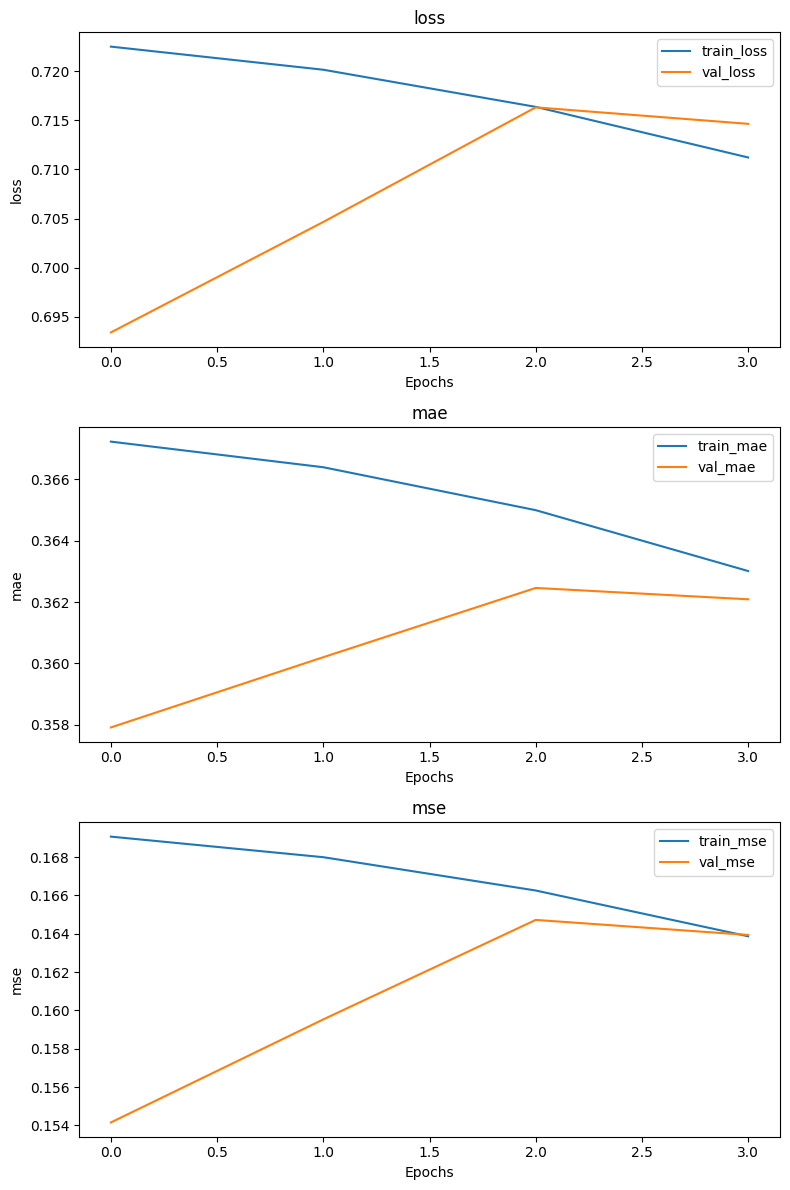

In [46]:
metrics = ['loss', 'mae', 'mse']

fig, axes = plt.subplots(len(metrics), 1, figsize=(8, len(metrics) * 4))

for i, metric in enumerate(metrics):
    axes[i].plot(history.history[metric], label='train_' + metric)
    axes[i].plot(history.history['val_' + metric], label='val_' + metric)
    axes[i].set_title(metric)
    axes[i].set_xlabel('Epochs')
    axes[i].set_ylabel(metric)
    axes[i].legend()
    
plt.tight_layout()
plt.show()

In [47]:
def extract_weights(name, model):
    weight_layer = model.get_layer(name)
    weights = weight_layer.get_weights()[0]
    weights = weights/np.linalg.norm(weights, axis=1).reshape((-1, 1))
    return weights

In [48]:
anime_weights = extract_weights('anime_embedding', model)
user_weights = extract_weights('user_embedding', model)

In [49]:
anime_weights

array([[-0.15533382, -0.08868618,  0.08939662, ..., -0.05381745,
         0.12927058,  0.1498729 ],
       [-0.07551412,  0.01031729,  0.02519865, ..., -0.10095456,
         0.10038478, -0.05123043],
       [-0.13868247, -0.06637021, -0.03816616, ...,  0.02128584,
        -0.00745578, -0.00631601],
       ...,
       [ 0.11171805,  0.13901412,  0.12585056, ..., -0.04682996,
         0.08118044,  0.13856979],
       [ 0.13179173,  0.11197732, -0.09526664, ...,  0.0310271 ,
        -0.02577289,  0.02930431],
       [-0.10874308, -0.01054996, -0.01747541, ..., -0.0680728 ,
         0.00967263, -0.06615081]], dtype=float32)

In [50]:
df = pd.read_csv('../artifacts/raw/anime.csv', low_memory=True)
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-10,Score-9,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,229170.0,182126.0,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0
1,5,Cowboy Bebop: Tengoku no Tobira,8.39,"Action, Drama, Mystery, Sci-Fi, Space",Cowboy Bebop:The Movie,カウボーイビバップ 天国の扉,Movie,1,"Sep 1, 2001",Unknown,...,30043.0,49201.0,49505.0,22632.0,5805.0,1877.0,577.0,221.0,109.0,379.0
2,6,Trigun,8.24,"Action, Sci-Fi, Adventure, Comedy, Drama, Shounen",Trigun,トライガン,TV,26,"Apr 1, 1998 to Sep 30, 1998",Spring 1998,...,50229.0,75651.0,86142.0,49432.0,15376.0,5838.0,1965.0,664.0,316.0,533.0
3,7,Witch Hunter Robin,7.27,"Action, Mystery, Police, Supernatural, Drama, ...",Witch Hunter Robin,Witch Hunter ROBIN (ウイッチハンターロビン),TV,26,"Jul 2, 2002 to Dec 24, 2002",Summer 2002,...,2182.0,4806.0,10128.0,11618.0,5709.0,2920.0,1083.0,353.0,164.0,131.0
4,8,Bouken Ou Beet,6.98,"Adventure, Fantasy, Shounen, Supernatural",Beet the Vandel Buster,冒険王ビィト,TV,52,"Sep 30, 2004 to Sep 29, 2005",Fall 2004,...,312.0,529.0,1242.0,1713.0,1068.0,634.0,265.0,83.0,50.0,27.0


In [51]:
df = df.replace("Unknown", np.nan)

In [52]:
def fetch_anime_name(anime_id):
    try:
        name = df[df.anime_id == anime_id].eng_version.values[0]
        if name is np.nan:
            name = df[df.anime_id == anime_id].Name.values[0]
        return name
    except IndexError:
        return "Unknown Anime"

In [53]:
df['anime_id'] = df['MAL_ID']
df['eng_version'] = df['English name']
df['eng_version'] = df.anime_id.apply(lambda x: fetch_anime_name(x))

In [54]:
df.head(1)

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",Cowboy Bebop,カウボーイビバップ,TV,26,"Apr 3, 1998 to Apr 24, 1999",Spring 1998,...,131625.0,62330.0,20688.0,8904.0,3184.0,1357.0,741.0,1580.0,1,Cowboy Bebop


In [55]:
fetch_anime_name(6702)

'Fairy Tail'

In [56]:
df.sort_values(by = ['Score'], inplace=True, ascending=False, kind = 'quicksort', na_position='last')

In [57]:
df.head()

,MAL_ID,Name,Score,Genres,English name,Japanese name,Type,Episodes,Aired,Premiered,...,Score-8,Score-7,Score-6,Score-5,Score-4,Score-3,Score-2,Score-1,anime_id,eng_version
3971,5114,Fullmetal Alchemist: Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",Fullmetal Alchemist:Brotherhood,鋼の錬金術師 FULLMETAL ALCHEMIST,TV,64,"Apr 5, 2009 to Jul 4, 2010",Spring 2009,...,199160.0,70045.0,20210.0,9308.0,3222.0,1536.0,2162.0,16806.0,5114,Fullmetal Alchemist:Brotherhood
15926,40028,Shingeki no Kyojin: The Final Season,9.17,"Action, Military, Mystery, Super Power, Drama,...",Attack on Titan Final Season,進撃の巨人 The Final Season,TV,16,"Dec 7, 2020 to ?",Winter 2021,...,26016.0,8793.0,2674.0,1336.0,588.0,382.0,514.0,11061.0,40028,Attack on Titan Final Season
5683,9253,Steins;Gate,9.11,"Thriller, Sci-Fi",Steins;Gate,STEINS;GATE,TV,24,"Apr 6, 2011 to Sep 14, 2011",Spring 2011,...,140914.0,57740.0,21375.0,11126.0,5061.0,2292.0,1678.0,5255.0,9253,Steins;Gate
14963,38524,Shingeki no Kyojin Season 3 Part 2,9.1,"Action, Drama, Fantasy, Military, Mystery, Sho...",Attack on Titan Season 3 Part 2,進撃の巨人 Season3 Part.2,TV,10,"Apr 29, 2019 to Jul 1, 2019",Spring 2019,...,110481.0,33662.0,8365.0,2974.0,1108.0,550.0,385.0,4169.0,38524,Attack on Titan Season 3 Part 2
9913,28977,Gintama°,9.1,"Action, Comedy, Historical, Parody, Samurai, S...",Gintama Season 4,銀魂°,TV,51,"Apr 8, 2015 to Mar 30, 2016",Spring 2015,...,21360.0,10215.0,3898.0,2311.0,952.0,648.0,1100.0,4508.0,28977,Gintama Season 4


In [58]:
df.columns

Index(['MAL_ID', 'Name', 'Score', 'Genres', 'English name', 'Japanese name',
       'Type', 'Episodes', 'Aired', 'Premiered', 'Producers', 'Licensors',
       'Studios', 'Source', 'Duration', 'Rating', 'Ranked', 'Popularity',
       'Members', 'Favorites', 'Watching', 'Completed', 'On-Hold', 'Dropped',
       'Plan to Watch', 'Score-10', 'Score-9', 'Score-8', 'Score-7', 'Score-6',
       'Score-5', 'Score-4', 'Score-3', 'Score-2', 'Score-1', 'anime_id',
       'eng_version'],
      dtype='object')

In [59]:
df = df[['anime_id', 'eng_version', 'Score', 'Genres', 'Episodes', 'Type', 'Premiered','Members']]

In [60]:
df.head(1)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
3971,5114,Fullmetal Alchemist:Brotherhood,9.19,"Action, Military, Adventure, Comedy, Drama, Ma...",64,TV,Spring 2009,2248456


In [61]:
def getAnimeFrame(anime, df):
    if isinstance(anime, int):
        return df[df['anime_id'] == anime]
    elif isinstance(anime, str):
        return df[df['eng_version'] == anime]

In [62]:
getAnimeFrame(6702, df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
4707,6702,Fairy Tail,7.68,"Action, Adventure, Comedy, Magic, Fantasy, Sho...",175,TV,Fall 2009,1312470


In [63]:
getAnimeFrame('Cowboy Bebop', df)

,anime_id,eng_version,Score,Genres,Episodes,Type,Premiered,Members
0,1,Cowboy Bebop,8.78,"Action, Adventure, Comedy, Drama, Sci-Fi, Space",26,TV,Spring 1998,1251960


In [64]:
cols = ['MAL_ID', 'Name', 'Genres','sypnopsis']

In [65]:
synopsis_df = pd.read_csv('../artifacts/raw/anime_with_synopsis.csv', low_memory=True, usecols=cols)

In [66]:
synopsis_df.head(1)

,MAL_ID,Name,Genres,sypnopsis
0,1,Cowboy Bebop,"Action, Adventure, Comedy, Drama, Sci-Fi, Space","In the year 2071, humanity has colonized sever..."


In [67]:
def getSynopsis(anime, synopsis_df):
    if isinstance(anime, int):

        return synopsis_df[synopsis_df['MAL_ID'] == anime].sypnopsis.values[0]
    elif isinstance(anime, str):
        return synopsis_df[synopsis_df['Name'] == anime].sypnopsis.values[0]

In [68]:
getSynopsis('One Piece', synopsis_df)

'Gol D. Roger was known as the "Pirate King," the strongest and most infamous being to have sailed the Grand Line. The capture and execution of Roger by the World Government brought a change throughout the world. His last words before his death revealed the existence of the greatest treasure in the world, One Piece. It was this revelation that brought about the Grand Age of Pirates, men who dreamed of finding One Piece—which promises an unlimited amount of riches and fame—and quite possibly the pinnacle of glory and the title of the Pirate King. Enter Monkey D. Luffy, a 17-year-old boy who defies your standard definition of a pirate. Rather than the popular persona of a wicked, hardened, toothless pirate ransacking villages for fun, Luffy\'s reason for being a pirate is one of pure wonder: the thought of an exciting adventure that leads him to intriguing people and ultimately, the promised treasure. Following in the footsteps of his childhood hero, Luffy and his crew travel across the 

In [69]:
getSynopsis(6702, synopsis_df)

"In the mystical land of Fiore, magic exists as an essential part of everyday life. Countless magic guilds lie at the core of all magical activity, and serve as venues for like-minded mages to band together and take on job requests. Among them, Fairy Tail stands out from the rest as a place of strength, spirit, and family. Lucy Heartfilia is a young mage searching for celestial gate keys, and her dream is to become a full-fledged wizard by joining this famous guild. In her search, she runs into Natsu Dragneel and his partner Happy, who are on a quest to find Natsu's foster father, the dragon Igneel. Upon being tricked by a man, Lucy falls under an abduction attempt, only to be saved by Natsu. To her shock, he reveals that he is a member of Fairy Tail and invites her to join them. There, Lucy meets the guild's strange members, such as the ice wizard Gray Fullbuster and magic swordswoman Erza Scarlet. Together as a family, they battle the forces of evil, help those in need, and gain new 

In [70]:
###Item based recommendations

pd.set_option('display.max_colwidth', None)

In [84]:
def find_similar_anime(name, anime_weights, anime2anime_encoder, anime2anime_decoder, df, synopsis_df, n = 10, return_dist= False, neg = False):
    try:
        index = getAnimeFrame(name, df).anime_id.values[0]
        encoded_index = anime2anime_encoder.get(index)
        if index is None:
            raise ValueError("Anime not found in the dataset.")
        weights = anime_weights
        dists = np.dot(weights, weights[encoded_index])
        sorted_dists = np.argsort(dists)
        n= n+1
        if neg :
            closest = sorted_dists[:n]
        else:
            closest = sorted_dists[-n:]
        print(f"Similar anime to {name}:\n")
        
        if return_dist:
            return dists,closest

        SimilarityArr =  []
        for close in closest:
            decoded_id = anime2anime_decoder.get(close)
            
            synopsis = getSynopsis(decoded_id, synopsis_df)
            anime_frame = getAnimeFrame(decoded_id, df)
            
            anime_name = anime_frame.eng_version.values[0]
            anime_genres = anime_frame.Genres.values[0]
            similarity = dists[close]
            
            SimilarityArr.append({
                'anime_id': decoded_id,
                'name': anime_name,
                'genres': anime_genres,
                'synopsis': synopsis,
                'score': similarity
            })
        Frame = pd.DataFrame(SimilarityArr).sort_values(by='anime_id', ascending=True)
        Frame = Frame[Frame.anime_id != index]
        return Frame[Frame.anime_id != index].drop(columns='anime_id', axis=1)
    except Exception as e:  
        raise ValueError(f"Error finding similar anime: {e}")
    

In [85]:
find_similar_anime('One Piece', anime_weights, anime2anime_encoder, anime2anime_decoder, df, synopsis_df, n=10)

Similar anime to One Piece:



,name,genres,synopsis,score
9,Kingyo Chuuihou! (Movie),"Action, Comedy, Kids, Shoujo",super-short fast paced theatrical animation about Wapiko and friends.,0.357131
1,Tenchi Muyo! War on Geminar,"Action, Comedy, Ecchi, Fantasy, Harem, Mecha, School","Kenshi Masaki has been kidnapped and brought to the world of Geminar by a mysterious group. To get back home, he agrees to help them assassinate the newly crowned empress of the Shtrayu Empire, Lashara Aasu XXVIII, using a giant robot called a Sacred Mechanoid. As her army fights them off, Lashara takes note of Kenshi's abilities and demands that her attacker be captured alive, only to find out that the pilot is male which is extremely rare on Geminar. Believing it to be a waste to kill him, she makes Kenshi her attendant. As the empress' new servant, Kenshi is required to accompany Lashara to the Holy Land, an academy where Sacred Mechanoid pilots hone their skills. His arrival attracts attention, but Kenshi is unaware that something sinister is brewing within the academy and it could plunge the entire world into war.",0.279286
8,Hakuoki ~Demon of the Fleeting Blossom~,"Action, Historical, Supernatural, Drama, Samurai, Josei","In 1864 Japan, a young woman named Chizuru Yukimura is searching for her missing father, Koudou, a doctor by trade whose work often takes him far from home. But with no word from him in months, Chizuru disguises herself as a man and heads to Kyoto in search of him. Attracting the attention of ronin, she tries to hide and ends up witnessing a horrifying sight: the ronin being brutally murdered by crazed white-haired men. In a startling turn of events, members of the Shinsengumi arrive to dispatch the creatures. But Chizuru's safety doesn't last long, as this group of men tie her up and take her back to their headquarters, unsure of whether to let her live or silence her permanently. However, once she reveals the name of her father, the Shinsengumi decide to keep her safe, as they too have been searching for him. But Koudou is more connected to the Shinsengumi than they let on, and soon Chizuru finds herself embroiled in a conflict between the Shinsengumi and their enemies, as well as political tension in Kyoto.",0.323195
3,Nippen no Miko-chan,Comedy,The official Twitter for Ballpoint pen writing image character Nippen no Miko-chan has announced that it will get anime CM series to broadcast within news discussion show 5-ji ni Muchuu on Tokyo MX. (Source: MAL News),0.292945
4,Bonobono: Uchuu kara Kita Tomodachi,"Adventure, Comedy, Kids","planetarium film for Bonobono screened on a full dome. Bonobono meets and alient hat looks just like him, together with everyone they go to space and explore the planets and stars. The film was first screened at the Shinagawa Gotanda Cultural Center Planetarium.",0.296218
2,Minion,"Music, Slice of Life, Fantasy",on works by Rabbit MACHINE and Tsubura are aesthetic loop animations with music.,0.287838
7,Wan Jie Shen Zhu 2nd Season,"Adventure, Fantasy",Second season of Wan Jie She Zhu .,0.303205
0,Uchida Shungicu no Noroi no One-Piece,"Horror, Romance, Shoujo",omnibus horror TV special where three girls encounter a beautiful rose patterned yellow one-piece dress which curses them as they try to gain the attention of a man they like in their lives.,0.277435
6,Sonna Yoru,Music,usic video directed by video production unit WHOPPERS (Naoya Sanuki and ZUCK) for the single Sonna Yoru by ENJOY MUSIC CLUB.,0.299004
5,Kaguya-sama wa Kokurasetai: Tensai-tachi no Renai Zunousen OVA,"Comedy, Psychological, Romance, School, Seinen",No synopsis information has been added to this title. Help improve our database by adding a synopsis here .,0.297738
